# Shallow donor in Si
Example of more complicated simulations, in which we compare the coherence predicted with point-dipole hyperfine couplings and one obtained using the hyperfines from model wavefunction of the shallow donor in Si (P:Si).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import ase

import pycce as pc


from mpl_toolkits import mplot3d

seed = 8800
np.set_printoptions(suppress=True, precision=5)

C:\Users\Daniel Low\Anaconda3\lib\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
import matplotlib as mpl  
mpl.rcParams['figure.figsize'] = [12.0, 8.0]

First, as always, generate spin bath with `BathCell` instance. To get parameters we use ase interface. It allows to conveniently read structure files of any type.

In [3]:
# Generate unitcell from ase
from ase import io
s = io.read('si.cif')
s = pc.bath.BathCell.from_ase(s)
# Add types of isotopes
s.add_isotopes(('29Si', 0.047))
# set z direction of the defect
s.zdir = [1, 1, 1]
# Generate supercell
atoms = s.gen_supercell(200, remove=[('Si', [0., 0., 0.])], seed=seed)

## Calculations with point dipole hyperfine couplings
Here we compute Hahn-echo decay with point dipole hyperfine couplings. All of the parameters are converged, however it never hurts to check!

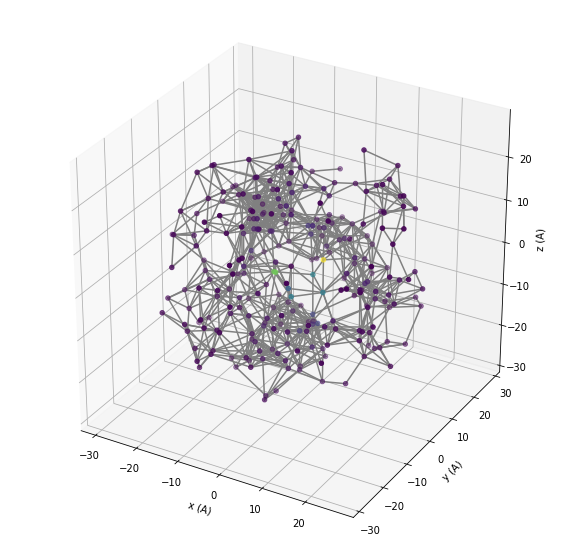

In [4]:
# Parameters of CCE calculations engine

# Order of CCE aproximation
CCE_order = 2
# Bath cutoff radius
r_bath = 30  # in A
# Cluster cutoff radius
r_dipole = 10  # in A

# position of central spin
position = [0, 0, 0]
# Qubit levels (in Sz basis)
alpha = [0, 1]; beta = [1, 0]
# Mag. Field (Bx By Bz)
B = np.array([0, 0, 1000])  # in G
# Number of pulses in CPMG seq (0 = FID, 1 = HE etc)
pulses = 1

# Setting the runner engine
calc = pc.Simulator(spin=0.5, position=position, alpha=alpha, beta=beta,
                    bath=atoms, r_bath=r_bath, magnetic_field=B, pulses=pulses,
                    r_dipole=r_dipole, order=CCE_order)

# add 3D axis
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# We want to visualize the smaller bath
data = calc.bath

# First plot the positions of the bath 
colors = np.abs(data.A[:,2,2]/data.A[:,2,2].max())
ax.scatter3D(data.x, data.y, data.z, c=colors, cmap='viridis');
# Plot all pairs of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 2
for c in calc.clusters[2]:
    ax.plot3D(data.x[c], data.y[c], data.z[c], color='grey')
# Plot all triplets of nuclear spins, which are contained
# in the calc.clusters dictionary under they key 3
#for c in calc.clusters[3]:
    #ax.plot3D(data.x[c], data.y[c], data.z[c], color='red', ls='--', lw=0.5)

ax.set(xlabel='x (A)', ylabel='y (A)', zlabel='z (A)');


In [5]:
# Time points
time_space = np.linspace(0, 2, 201)  # in ms

For comparison, we compute both with generalized CCE and usual CCE coherence. Note a relatively large bath (`r_bath = 80`), so the calculations will take some time.

In [6]:
l_cce = calc.compute(time_space, method='CCE')
l_gen = calc.compute(time_space, method='gCCE')

## Hyperfine couplings of the shallow donor

We compute the hyperfine couplings of the shallow donnor, following the formulae by Rogerio de Sousa and S. Das Sarma ([Phys Rev B 68, 115322 (2003)](https://doi.org/10.1103/PhysRevB.68.115322)).

In [7]:
# PHYSICAL REVIEW B 68, 115322 (2003)
n = 0.81
a = 25.09

def factor(x, y, z, n=0.81, a=25.09, b=14.43):
    top = np.exp(-np.sqrt(x**2/(n*b)**2 + (y**2 + z**2)/(n*a)**2))
    bottom = np.sqrt(np.pi * (n * a)**2 * (n * b) )

    return top / bottom

def contact_si(r, gamma_n, gamma_e=pc.ELECTRON_GYRO, a_lattice=5.43, nu=186, n=0.81, a=25.09, b=14.43):
    k0 = 0.85 * 2 * np.pi / a_lattice
    pre = 8 / 9 * gamma_n * gamma_e * pc.HBAR_MU0_O4PI * nu
    xpart = factor(r[0], r[1], r[2], n=n, a=a, b=b) * np.cos(k0 * r[0])
    ypart = factor(r[1], r[2], r[0], n=n, a=a, b=b) * np.cos(k0 * r[1])
    zpart = factor(r[2], r[0], r[1], n=n, a=a, b=b) * np.cos(k0 * r[2])
    return pre * (xpart + ypart + zpart) ** 2


We make a copy of the `BathArray` object, and set up their hyperfines according to the reference above.

In [8]:
newatoms = atoms.copy()

# Generate hyperfine from point dipole
newatoms.from_point_dipole(position)

# Following PRB paper
newatoms['A'][newatoms.dist() < n*a] = 0
newatoms['A'] += np.eye(3)[np.newaxis,:,:] * contact_si(newatoms['xyz'].T, newatoms.types['29Si'].gyro)[:,np.newaxis, np.newaxis]

Now we set up a `Simulator` object. Because hyperfines in `newatoms` are nonzero, they are **not** approximated as the ones of point dipole.

In [9]:
calc = pc.Simulator(spin=0.5, position=position, alpha=alpha, beta=beta,
                    bath=newatoms, r_bath=r_bath, magnetic_field=B, pulses=pulses,
                    r_dipole=r_dipole, order=CCE_order)

In [10]:
shallow_l_cce = calc.compute(time_space, method='CCE')
shallow_l_gen = calc.compute(time_space, method='gCCE')

## Compare the results

We find that the point dipole gives a poor agreement with the experimental data. Model wavefunction, on the countrary, produces great agreement with the experimental coherence time from work of Eisuke Abe et al. ([Phys Rev B 82, 121201(R) (2010)](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.82.121201)).

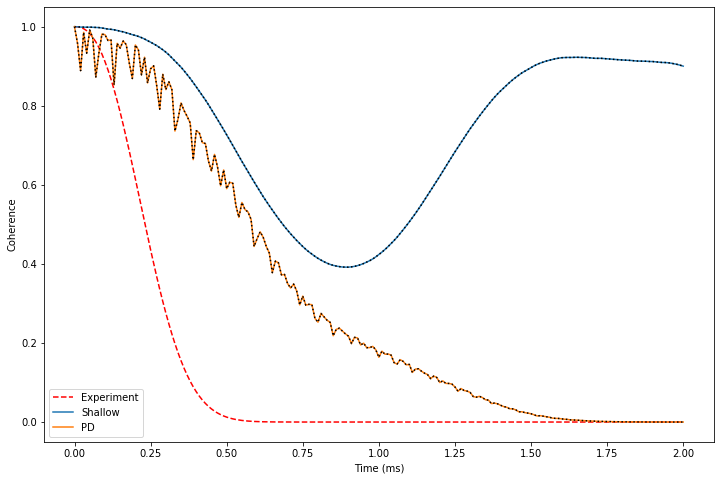

In [11]:
t2exp = 0.27 # Experimental T2 from PhysRevB.82.121201
decay = lambda t: np.exp(-(t/t2exp)**2.4)
plt.plot(time_space, decay(time_space), color='red', label='Experiment', ls='--')

plt.plot(time_space, shallow_l_cce.real, label='Shallow')
plt.plot(time_space, shallow_l_gen.real, ls=':', c='black')

plt.plot(time_space, l_cce.real, label='PD')
plt.plot(time_space, l_gen.real, ls=':', c='black')
plt.legend();
plt.xlabel('Time (ms)')
plt.ylabel('Coherence');

Interesting to note - the decay depends significantly on the orientation of the magnetic field. You can check it yourself!